In [1]:
train_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
import tensorflow as tf

mobilnet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

mobilnet.trainable=False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in mobilnet.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\AppData\Local\Temp\ipykernel_2368\3228279745.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000026EC80E29E0>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000026ED4275960>,conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000026ED4256F50>,conv1_bn,False
3,<keras.layers.activation.relu.ReLU object at 0x0000026ED4256D10>,conv1_relu,False
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000026ED42564A0>,conv_dw_1,False
...,...,...,...
81,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000026EF6B259C0>,conv_dw_13_bn,False
82,<keras.layers.activation.relu.ReLU object at 0x0000026EDADAD9F0>,conv_dw_13_relu,False
83,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000026EF6B25600>,conv_pw_13,False
84,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000026EF6B27340>,conv_pw_13_bn,False


In [7]:
mobilnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 16, 16, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 16, 16, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 16, 16, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 16, 16, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 16, 16, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 16, 16, 512)       262144    
                                                                 
 conv_pw_9

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = tf.keras.Sequential()
model.add(mobilnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2)                 131074    
                                                                 
Total params: 3,359,938
Trainable params: 131,074
Non-trainable params: 3,228,864
_________________________________________________________________
None


C:\Users\elium\.conda\envs\enviromentalGPU\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
history = model.fit_generator(train, 
                              epochs=15,  
                              validation_data=val,  
                              verbose=1)

Epoch 1/15


C:\Users\elium\AppData\Local\Temp\ipykernel_2368\1271991653.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,
C:\Users\elium\.conda\envs\enviromentalGPU\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


454/454 [==============================] - 32s 64ms/step - loss: 0.2733 - accuracy: 0.9174 - f1_m: 0.9040 - precision_m: 0.8704 - recall_m: 0.9418 - val_loss: 0.1304 - val_accuracy: 0.9560 - val_f1_m: 0.9407 - val_precision_m: 0.9169 - val_recall_m: 0.9671
Epoch 2/15
454/454 [==============================] - 29s 63ms/step - loss: 0.0769 - accuracy: 0.9736 - f1_m: 0.9567 - precision_m: 0.9339 - recall_m: 0.9816 - val_loss: 0.0983 - val_accuracy: 0.9671 - val_f1_m: 0.9507 - val_precision_m: 0.9285 - val_recall_m: 0.9748
Epoch 3/15
454/454 [==============================] - 27s 60ms/step - loss: 0.0357 - accuracy: 0.9867 - f1_m: 0.9683 - precision_m: 0.9484 - recall_m: 0.9898 - val_loss: 0.0838 - val_accuracy: 0.9712 - val_f1_m: 0.9548 - val_precision_m: 0.9337 - val_recall_m: 0.9779
Epoch 4/15
454/454 [==============================] - 27s 59ms/step - loss: 0.0151 - accuracy: 0.9974 - f1_m: 0.9771 - precision_m: 0.9606 - recall_m: 0.9946 - val_loss: 0.0867 - val_accuracy: 0.9723 - val_f

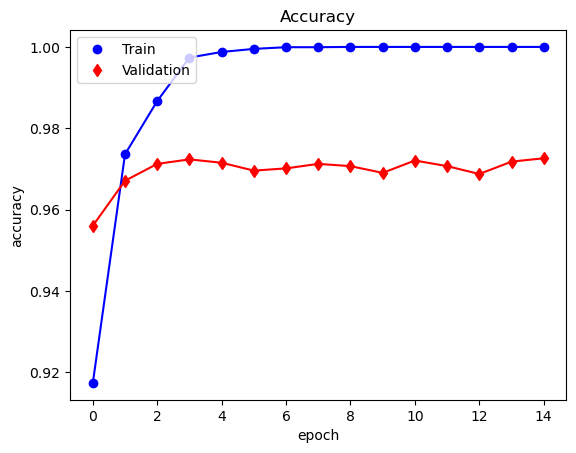

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],'o',color='blue')
plt.plot(history.history['val_accuracy'],'d',color='red')
plt.plot(history.history['accuracy'],color='blue')
plt.plot(history.history['val_accuracy'],color='red')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

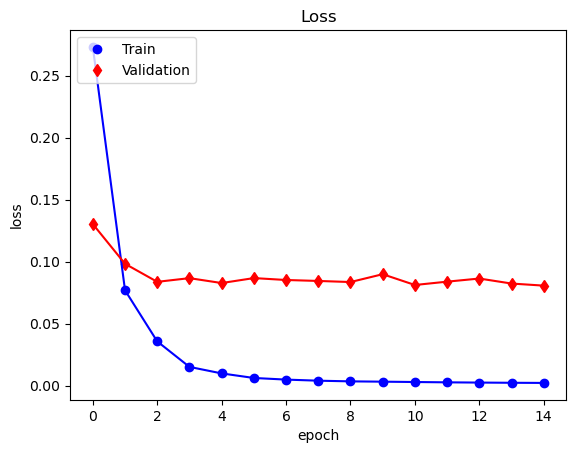

In [13]:
plt.plot(history.history['loss'],'o',color='blue')
plt.plot(history.history['val_loss'],'d',color='red')
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

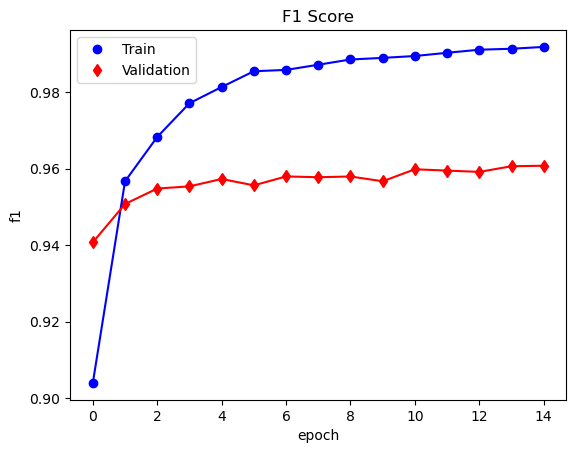

In [14]:
plt.plot(history.history['f1_m'],'o',color='blue')
plt.plot(history.history['val_f1_m'],'d',color='red')
plt.plot(history.history['f1_m'],color='blue')
plt.plot(history.history['val_f1_m'],color='red')
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

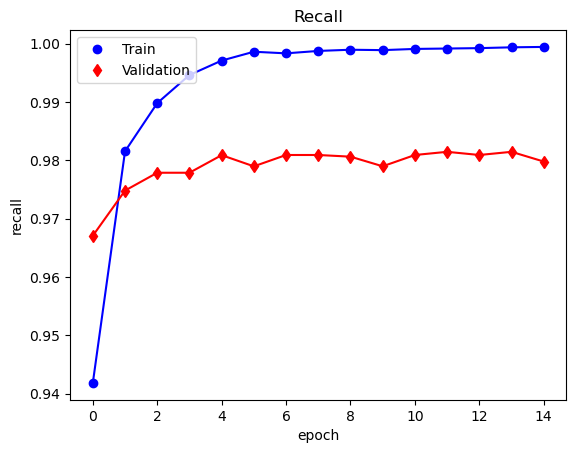

In [15]:
plt.plot(history.history['recall_m'],'o',color='blue')
plt.plot(history.history['val_recall_m'],'d',color='red')
plt.plot(history.history['recall_m'],color='blue')
plt.plot(history.history['val_recall_m'],color='red')
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

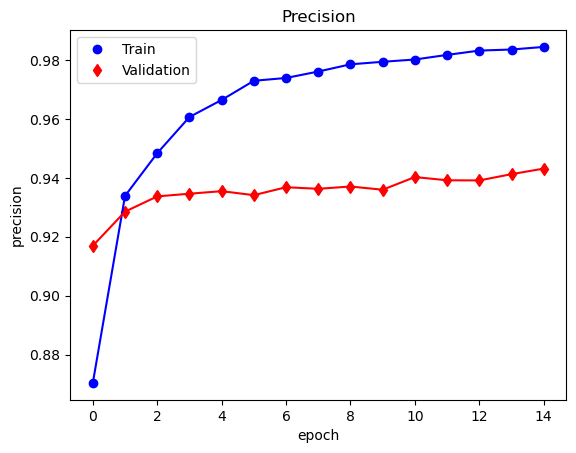

In [16]:
plt.plot(history.history['precision_m'],'o',color='blue')
plt.plot(history.history['val_precision_m'],'d',color='red')
plt.plot(history.history['precision_m'],color='blue')
plt.plot(history.history['val_precision_m'],color='red')
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
142/142 [==============================] - 7s 50ms/step - loss: 0.0743 - accuracy: 0.9753 - f1_m: 0.9638 - precision_m: 0.9465 - recall_m: 0.9823
El modelo predice el  97.53031730651855 % de los datos


In [18]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.07431641966104507
Accuracy:  0.9753031730651855
F1 Score:  0.9637619853019714
Precision:  0.9464967846870422
Recall:  0.9823082685470581
